The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


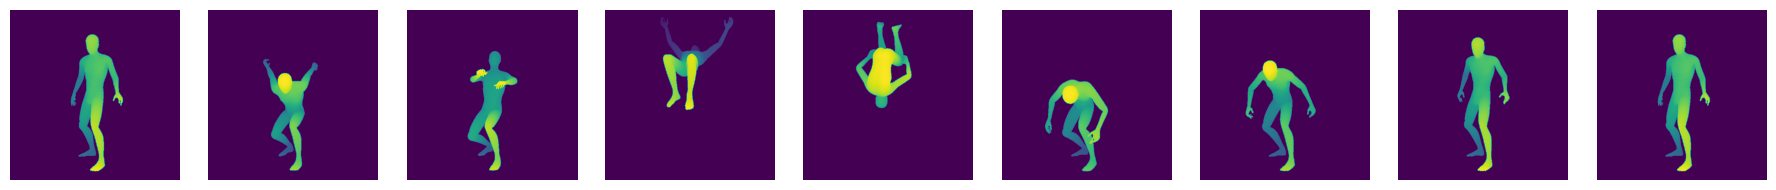

In [30]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.ipython_utils import display_ims
from text3d2video.rendering import render_depth_map

torch.set_grad_enabled(False)

animation_tag = 'cat_rotation_90:latest'
animation_tag = 'rumba:latest'
animation_tag = 'backflip:latest'

animation = AnimationArtifact.from_wandb_artifact_tag(animation_tag)
n_frames = 9
frame_indices = animation.frame_indices(n_frames)
cameras, mesh_frames = animation.load_frames(frame_indices)

depths = render_depth_map(mesh_frames, cameras)
display_ims(depths)

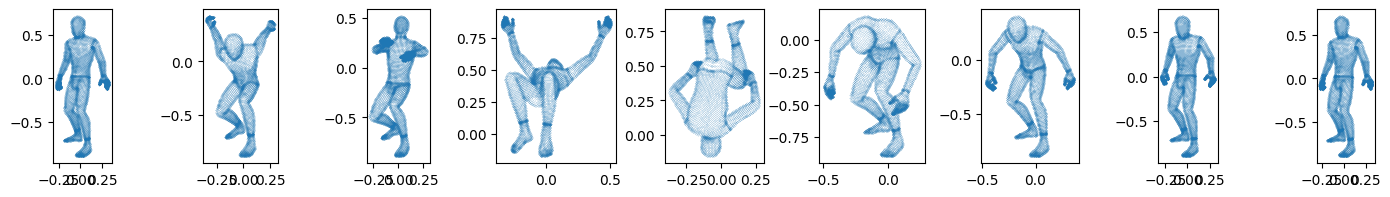

In [31]:
from matplotlib import pyplot as plt
from text3d2video.util import project_visible_verts_to_cameras


# lists of length n_frames
# coords: for each frame: 2D pos of each visible vert, tensor of shape (n_vertices, 2)
# indices: for each frame: index of each visible vert, tensor of shape (n_vertices)
visible_vert_coords, visible_vert_indices = project_visible_verts_to_cameras(
    mesh_frames, cameras
)

# plot visible vert coords
s = 2
fig, axs = plt.subplots(1, n_frames, figsize=(n_frames * s, s))
for i in range(n_frames):
    ax = axs[i]
    frame_visible_vert_coords = visible_vert_coords[i].cpu()
    ax.scatter(frame_visible_vert_coords[:, 0], frame_visible_vert_coords[:, 1], s=0.01)
    ax.set_aspect("equal")
    # ax.set_xticks([])
    # ax.set_yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


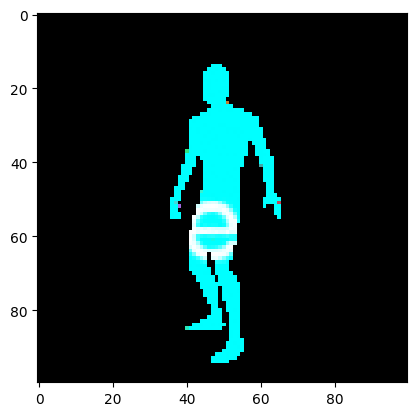

In [32]:
from text3d2video.rendering import make_feature_renderer
from text3d2video.util import sample_feature_map_ndc
from visual_tests.testing_utils import test_img
import torchvision.transforms.functional as TF
from pytorch3d.renderer import TexturesVertex


image = test_img(resolution=100, txt="ei", color="cyan")
feature_map = TF.to_tensor(image)

cam = cameras[0]
frame = mesh_frames[0]

# project vertices to camera, get 2D coords and indices of visible verts
vert_xys, vert_indices = project_visible_verts_to_cameras(frame, cam)
vert_xys = vert_xys[0]
vert_indices = vert_indices[0]

# initialize empty vertex features
num_verts = frame.num_verts_per_mesh()[0]
vert_features = torch.rand((num_verts, 3))

# sample feature map at visible vert coords
visible_vert_features = sample_feature_map_ndc(
    feature_map.cuda(),
    vert_xys.cuda(),
    mode='bilinear'
)
vert_features[vert_indices] = visible_vert_features.cpu()

renderer = make_feature_renderer(cam, 100, 'cuda')
tex = TexturesVertex(vert_features.expand(len(cam), -1, -1).cuda())
frame.textures = tex
render = renderer(frame)[0].cpu()
plt.imshow(render)

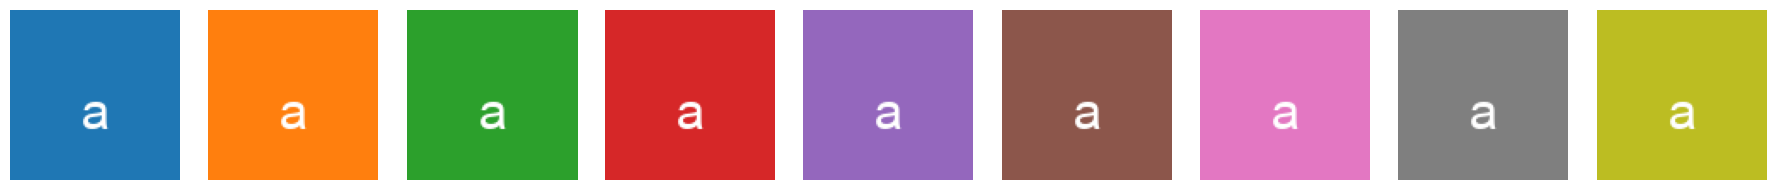

In [33]:
from matplotlib.cm import get_cmap
from text3d2video.ipython_utils import display_ims
from visual_tests.testing_utils import test_img
import torchvision.transforms.functional as TF

cmap = get_cmap('tab10')

indices = torch.arange(n_frames)
colors = cmap(indices)

images = [test_img(resolution=100, color=colors[i][0:3], txt="a") for i in range(n_frames)]
feature_maps = torch.stack([TF.to_tensor(img) for img in images])

display_ims(images)

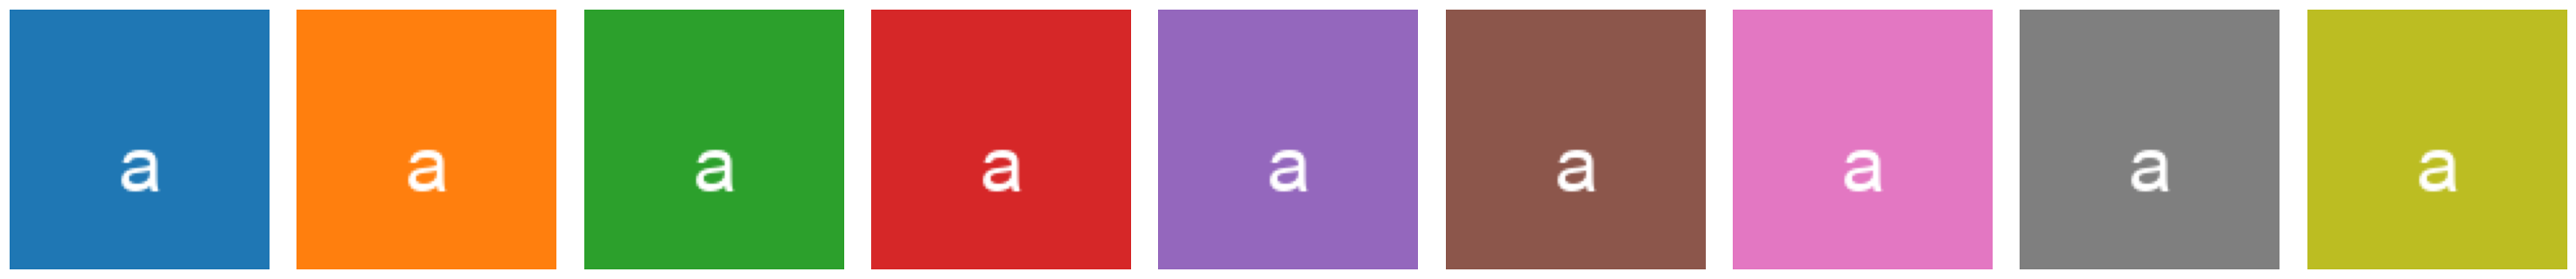

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid r

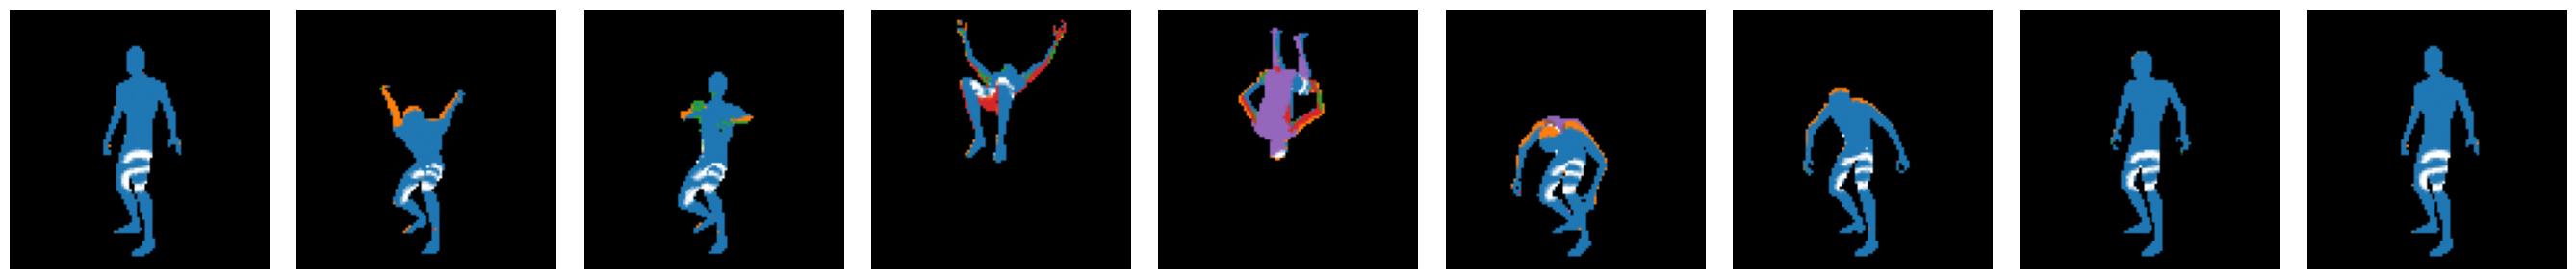

In [35]:
from text3d2video.ipython_utils import display_ims
import torchvision.transforms.functional as TF

from text3d2video.rendering import make_feature_renderer
from text3d2video.util import (
    aggregate_features_precomputed_vertex_positions,
)
from pytorch3d.renderer import TexturesVertex

res = 100
feature_dim = 3

vert_features_mean = aggregate_features_precomputed_vertex_positions(
    feature_maps.cuda(),
    mesh_frames.num_verts_per_mesh()[0],
    visible_vert_coords,
    visible_vert_indices,
    aggregation_type="first",
)

renderer = make_feature_renderer(cameras, res)
tex_mean = TexturesVertex(vert_features_mean.expand(n_frames, -1, -1))
mesh_frames.textures = tex_mean
feature_images = renderer(mesh_frames)

display_ims([TF.to_pil_image(map) for map in feature_maps], scale=3)
display_ims([img for img in feature_images.cpu()], scale=3)

In [45]:
import torchvision.transforms.functional as TF

from text3d2video.rendering import make_feature_renderer
from text3d2video.util import (
    aggregate_features_precomputed_vertex_positions,
)
from pytorch3d.renderer import TexturesVertex

res = 100
feature_dim = 3

vert_features_mean = aggregate_features_precomputed_vertex_positions(
    feature_maps.cuda(),
    mesh_frames.num_verts_per_mesh()[0],
    visible_vert_coords,
    visible_vert_indices,
    aggregation_type="mean",
)

vert_features_inpaint = aggregate_features_precomputed_vertex_positions(
    feature_maps.cuda(),
    mesh_frames.num_verts_per_mesh()[0],
    visible_vert_coords,
    visible_vert_indices,
    aggregation_type="first",
)

vert_features_both = torch.mean(torch.stack([vert_features_mean, vert_features_inpaint]), dim=0)

renderer = make_feature_renderer(cameras, res)

tex_mean = TexturesVertex(vert_features_mean.expand(n_frames, -1, -1))
tex_inpaint = TexturesVertex(vert_features_inpaint.expand(n_frames, -1, -1))
texture = TexturesVertex(vert_features_both.expand(n_frames, -1, -1))

mesh_frames.textures = tex_mean
feature_images_mean = renderer(mesh_frames)

mesh_frames.textures = tex_inpaint
feature_images_inpaint = renderer(mesh_frames)

mesh_frames.textures = texture
feature_images_both = renderer(mesh_frames)

feature_maps_im = [TF.to_pil_image(map) for map in feature_maps]
feature_images_mean_im = [img for img in feature_images_mean.cpu()]
feature_images_inpaint_im = [img for img in feature_images_inpaint.cpu()]
feature_images_both_im = [img for img in feature_images_both.cpu()]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid r

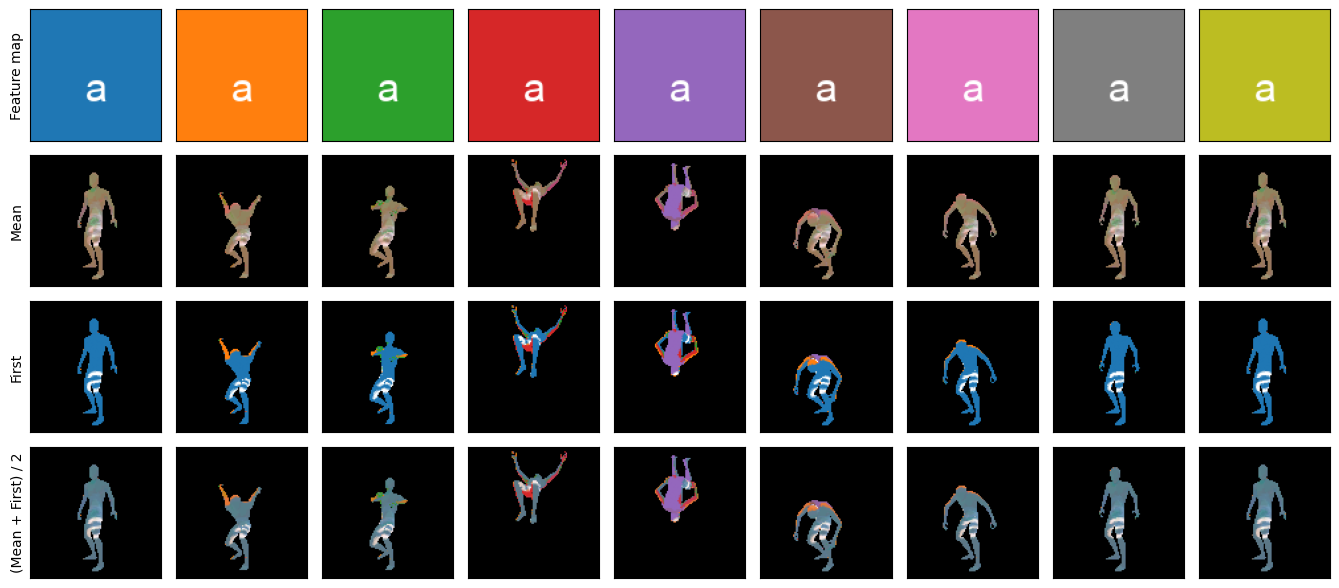

In [44]:
n_cols = n_frames
n_rows = 4

scale = 1.5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * scale, n_rows * scale))

for col_i in range(n_cols):

    ax_fmap = axs[0, col_i]
    ax_avg = axs[1, col_i]
    ax_inp = axs[2, col_i]
    ax_both = axs[3, col_i]

    ax_fmap.imshow(feature_maps_im[col_i])
    ax_avg.imshow(feature_images_mean_im[col_i])
    ax_inp.imshow(feature_images_inpaint_im[col_i])
    ax_both.imshow(feature_images_both_im[col_i])

    if col_i == 0:
        ax_fmap.set_ylabel("Feature map")
        ax_avg.set_ylabel("Mean")
        ax_inp.set_ylabel("First")
        ax_both.set_ylabel("(Mean + First) / 2")

    for ax in axs.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()


In [ ]:
from text3d2video.util import render_multiview
from text3d2video.video_util import pil_frames_to_clip

mesh = mesh_frames[0]
texture = TexturesVertex(vert_features_inpaint.unsqueeze(0))
mesh.textures = texture

frames = render_multiview(mesh, resolution=64)

pil_frames_to_clip(frames).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


: 